# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni DSLab computers according to the README.MD instructions without ANY exceptions on the DSLab machines: 3pt
2. Perfect 1:1 reproducibility on DSLab machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test". 

In [17]:
### IMPORTS ###

import torch
import numpy as np
import torch.nn as nn
from time import time
import torch.nn.functional as F
from torchvision import datasets
from datetime import datetime as dt
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [6]:
### DEVICE ###
# Use the GPU to speed up the training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
### SEED FOR REPRODUCIBILITY ###
random_seed = 13
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)





In [8]:
### HYPER-PARAMETERS ###

# Model training
workers = 8
batch_size = 16
num_epochs = 40
lr = 0.01
momentum = 0.75

In [9]:
### DATA LOADING ###
# This section loads the data from the train and test folders and applies the transformations
# All the images are resized to 256x256 pixels and normalized
# The training data is augmented with random transformations

# Define the transformations for the data
train_transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomApply([v2.TrivialAugmentWide()], p=0.5),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Collect the data and set the augmentation
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform) 

# Prepare the data loaders with the batches, shuffling, and workers
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=workers)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=workers)


# CNN Implementation

In [11]:
### MODEL TOPOLOGY DEFINITION ###

class Block(nn.Module):
    def __init__(self, in_channels, mid_channels, stride=1, expansion=4):
        super().__init__()
        # Convolutional block
        self.layer = nn.Sequential(nn.Conv2d(in_channels, mid_channels, 1, 1, 0),
                                   nn.SELU(),
                                   nn.BatchNorm2d(mid_channels),
                                   nn.Conv2d(mid_channels, mid_channels, 3, stride, 1),
                                   nn.SELU(),
                                   nn.Conv2d(mid_channels, mid_channels*expansion, 1, 1, 0),
                                   nn.BatchNorm2d(mid_channels*expansion))

        # In case the dimensionality of the data changes
        self.proj = False
        if in_channels != (mid_channels*expansion) or stride != 1:
            self.proj = True
            self.p_layer = nn.Conv2d(in_channels, mid_channels*4, 1, stride)

    def forward(self, x):
        res = x
        out = self.layer(x)
        # Add the residual of the original data to allow for an identity function
        if self.proj:
            res = self.p_layer(x)
        return nn.SELU()(out+res)


class FoodCNN(nn.Module):
    """
    Made to emulate the Residual Network.
    """
    def __init__(self, num_blocks=None):
        super().__init__()
        if num_blocks is None:
            num_blocks = [3, 4, 6, 3]
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                    nn.SELU(),
                                    nn.MaxPool2d(3, 2, 1))          # 64

        self.layer2 = self._make_layer(64, 64, num_blocks[0], 1)
        self.layer3 = self._make_layer(256, 128, num_blocks[1])     # 32
        self.layer4 = self._make_layer(512, 256, num_blocks[2])     # 16
        self.layer5 = self._make_layer(1024, 512, num_blocks[3])    # 8

        self.layer6 = nn.Sequential(nn.AvgPool2d(8),
                                    nn.Flatten(),
                                    nn.Dropout(0.25),
                                    nn.Linear(2048, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(0.25),
                                    nn.Linear(1024, 91))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x
    
    def _make_layer(self, in_channels, mid_channels, blocks, stride=2, expansion=4):
        layers = [Block(in_channels, mid_channels, stride, expansion)]
        for _ in range(1, blocks):
            layers.append(Block(mid_channels*expansion, mid_channels, expansion=expansion))
        return nn.Sequential(*layers)


# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [12]:
### TRAINING FUNCTIONS ###

def train(model, dataloader, optimizer, loss_fn, updates):
    """
    One epoch of model training.
    """

    
    model.train()

    running_loss = 0.0
    running_accuracy = 0.0

    total_loss = 0.0
    total_accuracy = 0.0
    
    for idx, data in enumerate(dataloader):
        images, labels = data[0].to(device), data[1].to(device)

        # Forward propagate
        optimizer.zero_grad()
        outputs = model(images)
        correct = sum(labels == torch.argmax(outputs, 1)).item()
        acc = correct/batch_size
        running_accuracy += acc
        total_accuracy += acc

        # Back-propagate and optimize
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Print a snapshot of the training
        if idx % updates == (updates-1):
            avg_loss_across_batches = running_loss / updates
            avg_acc_across_batches = (running_accuracy / updates) * 100
            print('Batch {}, Loss: {:.3f}, Accuracy: {:.2f}%'.format(idx+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0.0
            running_accuracy = 0.0

    avg_loss = total_loss / (idx+1)
    avg_accuracy = (total_accuracy / (idx+1)) * 100

    print('Training loss: {:.3f}, accuracy: {:.2f}%'.format(avg_loss, avg_accuracy))
    return avg_accuracy, avg_loss


def accuracy(model, dataloader, loss_fn):
    """
    One test accuracy test, can be used for validation as well.
    """
    model.eval()

    running_loss = 0.0
    running_accuracy = 0.0
    for data in iter(dataloader):
        images, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = model(images)
            correct = sum(labels == torch.argmax(outputs, 1)).item()
            running_accuracy += correct/batch_size
            
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(dataloader)
    avg_acc_across_batches = (running_accuracy / len(dataloader)) * 100
    
    print('Testing loss: {:.3f}, accuracy: {:.2f}%'.format(avg_loss_across_batches, avg_acc_across_batches))
    return avg_acc_across_batches, avg_loss_across_batches


def run_epochs(num_epochs, model, optimizer, loss_fn, scheduler=None, epoch=0, best_acc=0.0, max_strikes=5, updates=500):
    """
    An entire training session.
    """
    strikes = 0
    upper = epoch+num_epochs
    train_accuracies, train_losses = [], []
    test_accuracies, test_losses = [], []
    
    for epoch in range(epoch, upper):
        # Start epoch
        print(f"Epoch {epoch+1} begin: {dt.now()}.")
        start = time()

        # Train the model
        train_acc, train_loss = train(model, train_loader, optimizer, loss_fn, updates)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        print('Completed training after {:.2f} seconds.'.format((time() - start)))
        check_point = time()

        # Test the model
        test_acc, test_loss = accuracy(model, test_loader, loss_fn)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        print('Completed testing after {:.2f} seconds.'.format((time() - check_point)))

        # Update learning rate
        if scheduler is not None:
            scheduler.step(test_loss)

        # Output an update
        print('Total epoch time: {:.2f} seconds.'.format((time() - start)))
        print('Epoch [{}/{}]'.format(epoch+1, upper))
        check_point = time()

        # Save best model
        if best_acc < test_acc:
            best_acc = test_acc
            print("Check-point!")
            torch.save(model.state_dict(), "./checkpoint.pth")
        else:
            strikes += 1
            if strikes > max_strikes:
                print('It started overfitting!')
                break
            
        print("####################################################################################################")
    return train_accuracies, train_losses, test_accuracies, test_losses

In [13]:
### TRAINING ###

# Create model object and connect it to the corresponding processing
model = FoodCNN().to(device)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


train_accuracies, train_losses, test_accuracies, test_losses = run_epochs(num_epochs, model, optimizer, loss_fn, max_strikes=5, updates=285)

Epoch 1 begin: 2025-05-16 19:18:59.986046.
Batch 285, Loss: 4.553, Accuracy: 2.35%
Batch 570, Loss: 4.467, Accuracy: 2.76%
Batch 855, Loss: 4.421, Accuracy: 3.60%
Batch 1140, Loss: 4.403, Accuracy: 3.29%
Batch 1425, Loss: 4.339, Accuracy: 3.42%
Batch 1710, Loss: 4.322, Accuracy: 3.97%
Batch 1995, Loss: 4.276, Accuracy: 4.56%
Batch 2280, Loss: 4.232, Accuracy: 6.14%
Batch 2565, Loss: 4.229, Accuracy: 5.11%
Batch 2850, Loss: 4.172, Accuracy: 6.21%
Training loss: 4.341, accuracy: 4.14%
Completed training after 319.27 seconds.
Testing loss: 4.044, accuracy: 8.10%
Completed testing after 58.14 seconds.
Total epoch time: 377.42 seconds.
Epoch [1/40]
Check-point!
####################################################################################################
Epoch 2 begin: 2025-05-16 19:25:18.382722.
Batch 285, Loss: 4.148, Accuracy: 6.71%
Batch 570, Loss: 4.130, Accuracy: 6.69%
Batch 855, Loss: 4.112, Accuracy: 7.32%
Batch 1140, Loss: 4.095, Accuracy: 7.52%
Batch 1425, Loss: 4.054, Accur

KeyboardInterrupt: 

In [ ]:
model, random_seed, batch_size, lr, momentum

# Calculating model performance
Load the best version of your model ( which should be produced and saved by previous cells ), calculate and report the test accuracy.

In [41]:
### MODEL COMPARISONS ###

# Load the best model weights
device = torch.device("cpu")
model = FoodCNN().to(device)
#model.load_state_dict(torch.load("checkpoint.pth", weights_only=True))

# Calculate and present final scores
#final_test_acc = accuracy(model, test_loader, loss_fn)
print(f"Final Test Accuracy: {final_test_acc[0]:.2f}%")


Final Test Accuracy: 7.51%


# Summary of hyperparameters
Report the hyperparameters ( learning rate etc ) that you used in your final model for reproducibility.

# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

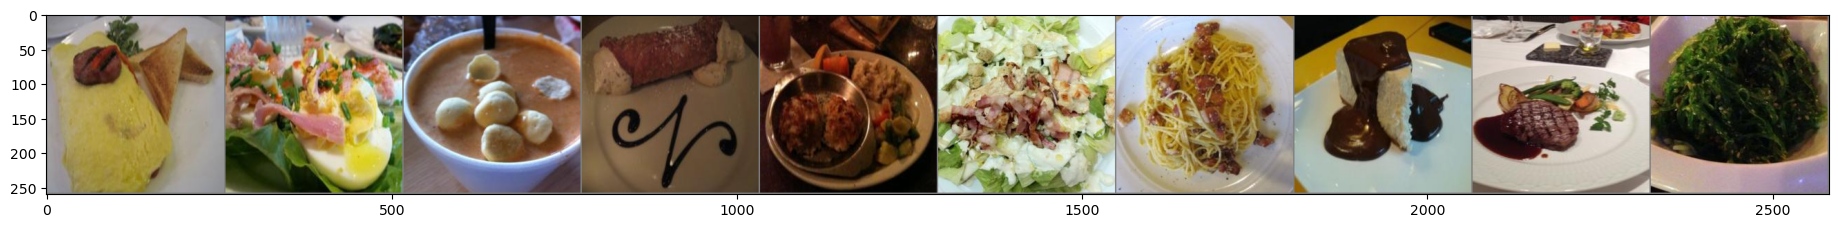

 omelette| deviled_eggs| lobster_bisque|  cannoli | crab_cakes| caesar_salad| spaghetti_carbonara| cheesecake|   steak  | seaweed_salad|
crab_cakes|  churros  | grilled_salmon| guacamole | guacamole | pork_chop | fish_and_chips| fish_and_chips| guacamole |  ravioli  |


In [65]:
# Your code here
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    fig = plt.gcf()
    fig.set_size_inches((23,9))
    
    plt.show()

# get some random training images
random_seed = 13
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

test_loader = DataLoader(test_dataset, 10, shuffle=True)
dataiter = iter(test_loader)
images, labels = next(dataiter)
with torch.no_grad():
    outputs = model(images.to(device))
    outputs = torch.argmax(outputs, 1)
    correct = sum(labels == outputs).item()

# show images
imshow(make_grid(images, nrow=10))
# print labels
print(' '.join(f'{test_dataset.classes[labels[j]]:5s}'.center(9)+'|' for j in range(10)))
print(' '.join(f'{test_dataset.classes[outputs[j]]:5s}'.center(10)+'|' for j in range(10)))




# Bonus point
Use an LLM (API) to generate a description of the food preference of a user based on 10 images that a potential user could provide. 
Please include an example of the output of your code, especially if you used an API other than the OpenAI API.

This should work well even with differing test images by setting different random seeds for the image selector.